<a href="https://colab.research.google.com/github/royam0820/ChatGPT-Google/blob/main/amr_Langchain_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the LLM to write and run SQL

In [1]:
# connecting to a google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# the database we are going to use.
!ls

drive  sample_data


In [3]:
%cd /content/drive/MyDrive/data/db

/content/drive/MyDrive/data/db


In [4]:
# Getting the OpenAI api key
import os
os.environ['OPENAI_API_KEY'] = "YOUR OWN OPENAI KEY"

In [5]:
!pip install langchain -q
!pip install openai -q
import langchain 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.7/520.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 3.2 MB/s eta 0:00:00


In [6]:
from langchain import OpenAI, SQLDatabase, SQLDatabaseChain


In [7]:
uri = "sqlite:////content/drive/MyDrive/data/db/E__sm_app.sqlite"

In [8]:
# calling SQLDatabaseChain to execute SQL queries
db = SQLDatabase.from_uri("sqlite:////content/drive/MyDrive/chatbot_knowledge/db/E__sm_app.sqlite")
llm = OpenAI(temperature=0)
db_chain = SQLDatabaseChain(
    llm=llm,
    database=db,
    verbose=True,  # Show it works
    return_direct=True,  # Return the results without sending back to the LLM
)

NB: For data-sensitive projects, you can specify `return_direct=True` in the `SQLDatabaseChain` initialization to directly return the output of the SQL query without any additional formatting. This prevents the LLM from seeing any contents within the database. Note, however, the LLM still has access to the database scheme (i.e. dialect, table and key names) by default.

In [9]:
# doing a simple connect to the database 
import sqlite3
db = sqlite3.connect('/content/drive/MyDrive/chatbot_knowledge/db/E__sm_app.sqlite')


In [10]:
# and then simply querying the database
cursor = db.cursor()
cursor.execute("SELECT * FROM users")
rows = cursor.fetchall(); rows

[(1, 'James', 25, 'male', 'USA'),
 (2, 'Leila', 32, 'female', 'France'),
 (3, 'Brigitte', 35, 'female', 'England'),
 (4, 'Mike', 40, 'male', 'Denmark'),
 (5, 'Elizabeth', 21, 'female', 'Canada')]

In [11]:
# and then simply querying the database
cursor = db.cursor()
cursor.execute("SELECT COUNT(*) FROM users")
rows = cursor.fetchall(); rows

[(5,)]

In [12]:
# executing a langchain db SQL instruction
db_chain.run("How many employees are there?")



> Entering new SQLDatabaseChain chain...
How many employees are there? 
SQLQuery: SELECT COUNT(*) FROM users;
SQLResult: [(5,)]
> Finished chain.


'[(5,)]'

NB1: you can also simply call `db_chain("How many employees are there?"`

NB2: With the `db_chain` initialization with `verbose=True` we have a complete SQL information corresponding to the llm query.

In [13]:
# sqlite3 query
cursor.execute("SELECT COUNT(*) FROM users")
rows = cursor.fetchall()
print("number of users: ", rows)

number of users:  [(5,)]


NB: the table `users` has 25 records.

In [14]:
# db_chain llm query
db_chain.run("give me their names?")



> Entering new SQLDatabaseChain chain...
give me their names? 
SQLQuery: SELECT name FROM users LIMIT 5;
SQLResult: [('James',), ('Leila',), ('Brigitte',), ('Mike',), ('Elizabeth',)]
> Finished chain.


"[('James',), ('Leila',), ('Brigitte',), ('Mike',), ('Elizabeth',)]"

NB: by default, the SQL query generated from the llm query impose a limit to 5: `LIMIT 5`

In [15]:
# db_chain llm query requesting no limit for the retrieval of users
db_chain.run("give me their names, no limit")



> Entering new SQLDatabaseChain chain...
give me their names, no limit 
SQLQuery: SELECT name FROM users;
SQLResult: [('James',), ('Leila',), ('Brigitte',), ('Mike',), ('Elizabeth',)]
> Finished chain.


"[('James',), ('Leila',), ('Brigitte',), ('Mike',), ('Elizabeth',)]"

In [17]:
# db_chain llm query
db_chain.run("give me users in France, no limit")



> Entering new SQLDatabaseChain chain...
give me users in France, no limit 
SQLQuery: SELECT name, age, gender FROM users WHERE nationality = 'France'
SQLResult: [('Leila', 32, 'female'), ('Leila', 32, 'female'), ('Leila', 32, 'female')]
> Finished chain.


"[('Leila', 32, 'female'), ('Leila', 32, 'female'), ('Leila', 32, 'female')]"

In [16]:
# checking for duplicate values in the users table
cursor = db.cursor()
cursor.execute("SELECT name FROM users GROUP BY name HAVING COUNT(*) > 1")
rows = cursor.fetchall(); rows

[]

In [19]:
# db_chain llm query
db_chain.run("delete duplicate values from the users table")



> Entering new SQLDatabaseChain chain...
delete duplicate values from the users table 
SQLQuery: DELETE FROM users WHERE id NOT IN (SELECT MIN(id) FROM users GROUP BY name, age, gender, nationality);
SQLResult: 
> Finished chain.


''

NB: not bad! a simple llm query was able to produce the right sql!

In [20]:
# db_chain llm query
db_chain.run("display the results")



> Entering new SQLDatabaseChain chain...
display the results 
SQLQuery: SELECT name, age, gender, nationality FROM users LIMIT 5
SQLResult: [('James', 25, 'male', 'USA'), ('Leila', 32, 'female', 'France'), ('Brigitte', 35, 'female', 'England'), ('Mike', 40, 'male', 'Denmark'), ('Elizabeth', 21, 'female', 'Canada')]
> Finished chain.


"[('James', 25, 'male', 'USA'), ('Leila', 32, 'female', 'France'), ('Brigitte', 35, 'female', 'England'), ('Mike', 40, 'male', 'Denmark'), ('Elizabeth', 21, 'female', 'Canada')]"

In [17]:
# db_chain query showing duplicates eliminated.
db_chain.run("give me total count of users")



> Entering new SQLDatabaseChain chain...
give me total count of users 
SQLQuery: SELECT COUNT(*) FROM users;
SQLResult: [(5,)]
> Finished chain.


'[(5,)]'

In [18]:
db_chain("What is the average age for each party?")




> Entering new SQLDatabaseChain chain...
What is the average age for each party? 
SQLQuery: SELECT gender, AVG(age) FROM users GROUP BY gender;
SQLResult: [('female', 29.333333333333332), ('male', 32.5)]
> Finished chain.


{'query': 'What is the average age for each party?',
 'result': "[('female', 29.333333333333332), ('male', 32.5)]"}

# Using the LLM to Visualize the Data

In [19]:
from langchain import LLMChain

In [20]:
from langchain.agents import (AgentExecutor, Tool, ZeroShotAgent,
                              initialize_agent, load_tools)


In [21]:
# Add python_repl to our list of tools
tools = load_tools(["python_repl"])

# Define our voter_data tool

# Set a description to help the LLM know when and how to use it.
description = (
    "Useful for when you need to answer questions about users. "
    "You must not input SQL. Use this more than the Python tool if the question "
    "is about user data, like 'what is the users age repartition?' or 'count the number of users'"
)

user_data = Tool(
    name="Data",  # We'll just call it 'Data'
    func=db_chain.run,
    description=description,
)

tools.append(user_data)

NB: `python_repl`  (Read-Eval-Print Loop), allows you to run Python code interactively while working on a project or learning the language. This tool is available in every Python installation, so you can use it at any moment

In [22]:
# Standard prefix
prefix = "Fulfill the following request as best you can. You have access to the following tools:"

# Remind the agent of the Data tool, and what types of input it expects
suffix = (
    "Begin! When looking for data, do not write a SQL query. "
    "Pass the relevant portion of the request directly to the Data tool in its entirety."
    "\n\n"
    "Request: {input}\n"
    "{agent_scratchpad}"
)

# The agent's prompt is built with the list of tools, prefix, suffix, and input variables
prompt = ZeroShotAgent.create_prompt(
    tools, prefix=prefix, suffix=suffix, input_variables=["input", "agent_scratchpad"]
)

# Set up the llm_chain
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Specify the tools the agent may use
tool_names = [tool.name for tool in tools]
agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)

# Create the AgentExecutor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True
)

NB: `AgentExecutor.from_agent_and_tools` Some applications will require not just a predetermined chain of calls to LLMs/other tools, but potentially an unknown chain that depends on the user’s input. In these types of chains, there is a “agent” which has access to a suite of tools. Depending on the user input, the agent can then decide which, if any, of these tools to call.



> Entering new AgentExecutor chain...

Thought: I need to get the age repartition of users
Action: Data
Action Input: age repartition

> Entering new SQLDatabaseChain chain...
age repartition 
SQLQuery: SELECT age, COUNT(*) FROM users GROUP BY age LIMIT 5
SQLResult: [(21, 1), (25, 1), (32, 1), (35, 1), (40, 1)]
> Finished chain.

Observation: [(21, 1), (25, 1), (32, 1), (35, 1), (40, 1)]
Thought: I need to plot this data
Action: Python REPL
Action Input: import matplotlib.pyplot as plt; plt.pie([x[1] for x in [(21, 1), (25, 1), (32, 1), (35, 1), (40, 1)]], labels=[x[0] for x in [(21, 1), (25, 1), (32, 1), (35, 1), (40, 1)]])
Observation: 
Thought: I now know the final answer
Final Answer: A pie chart representing the age repartition among users.

> Finished chain.


'A pie chart representing the age repartition among users.'

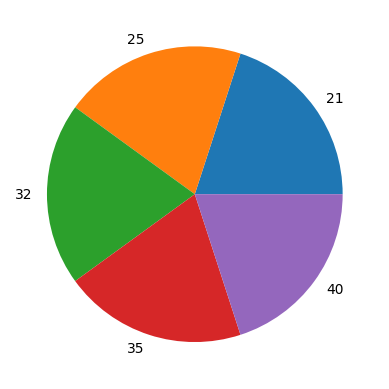

In [23]:
request = "Plot a pie representing the age repartition among users"

agent_executor.run(request)

# Resources
- [langchain with sqllite](https://python.langchain.com/en/latest/modules/chains/examples/sqlite.html)